# Random Forest miRNA
Runs RandomForestClassifier on miRNA data.  

Three datasets are analyzed using the RandomForest classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
RandomForestClassifier's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# trying to supress sklearn warning
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import make_mirna_nanostring_df, make_study_df, param_search_cv, param_search, \
    plot_shap_feature_importance, plot_xgb_feature_importance, combine_shap_heatmaps, \
    plot_shap_summary, plot_shap_heatmap, plot_shap_dependence, plot_shap_importance_with_summary, top_shap_values

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
! python --version

Python 3.13.0


In [3]:
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

sklearn version 1.3.0
shap version 0.42.1


---

## load miRNA data

In [5]:
file_names = [
    '../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
    '../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
    '../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
    '../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
    '../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
    '../data/Streptococcus_gordonii/16 weeks SHAM infection.csv',
    '../data/Tannerella_forsythia/8 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/8 weeks SHAM RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/8 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/8 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/16 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/16 weeks SHAM RAW data.csv'
]
cohort_names = [
    'inf_fn_8_weeks', 'sham_fn_8_weeks', 'inf_fn_16_weeks', 'sham_fn_16_weeks',
    'inf_pg_8_weeks', 'sham_pg_8_weeks', 'inf_pg_16_weeks', 'sham_pg_16_weeks',
    'inf_sg_8_weeks', 'sham_sg_8_weeks', 'inf_sg_16_weeks', 'sham_sg_16_weeks',
    'inf_tf_8_weeks', 'sham_tf_8_weeks', 'inf_tf_16_weeks', 'sham_tf_16_weeks',
    'inf_td_8_weeks', 'sham_td_8_weeks', 'inf_td_16_weeks', 'sham_td_16_weeks'
]
list(zip(file_names, cohort_names))

[('../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
  'inf_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
  'sham_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
  'inf_fn_16_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
  'sham_fn_16_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
  'inf_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
  'sham_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
  'inf_pg_16_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
  'sham_pg_16_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
  'inf_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
  'sham_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
  'inf_sg_16_

In [6]:
miRNA_df = make_mirna_nanostring_df(file_names, cohort_names)
miRNA_df.shape

(200, 604)

## create dataframes and X, y datasets

In [7]:
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks', infected_str='inf_')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks', infected_str='inf_')
df_all_weeks = make_study_df(miRNA_df, infected_str='inf_')

In [8]:
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']

---

## search for best params

In [9]:
# see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# n_estimators: Number of trees in random forest
# max_features: Number of features to consider at every split
# max_depth: Maximum number of levels in tree
# min_samples_split: Minimum number of samples required to split a node
# min_samples_leaf: Minimum number of samples required at each leaf node
# bootstrap: Method of selecting samples for training each tree
# oob_score: (bool) Whether to use out-of-bag samples to estimate the generalization score
random_grid = {
    'criterion' :['gini', 'entropy'],
    'n_estimators': list(range(10, 301, 10)), # [10, 20, 30, ... 300]
    'max_features': ['sqrt','log2', None],
    'max_depth': list(range(10, 201, 10)) + [None],# [10, 20, 30, ... 200, None]
    'min_samples_split': list(range(2, 11, 2)), # [2, 4, 6, ... 10]
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'random_state': list(range(0, 9, 10)) # [0, 3, 6, 9]
}

In [10]:
# used for testing single param search
# params_8_weeks = \
#     param_search(random_grid, X_8_weeks, y_8_weeks, RandomForestClassifier, cv=5)

### this code block takes a while to run, uncomment to run it

In [11]:
# cv_range = range(2, 11)
# clf = RandomForestClassifier
# 
# print('** 8 weeks params **')
# params_8_weeks_cv = \
#     param_search_cv(
#         random_grid, X_8_weeks, y_8_weeks, clf, cvs=cv_range, print_best=True)
# 
# print('** 16 weeks params **')
# params_16_weeks_cv = \
#     param_search_cv(
#         random_grid, X_16_weeks, y_16_weeks, clf, cvs=cv_range, print_best=True)
# 
# print('** All weeks params **')
# params_8_weeks_cv = \
#     param_search_cv(
#         random_grid, X_all_weeks, y_all_weeks, clf, cvs=cv_range, print_best=True)

### assign best params

In [12]:
params_8_weeks = \
    {
        'bootstrap': False,
        'criterion': 'gini',
        'max_depth': 90,
        'max_features': None,
        'min_samples_leaf': 2,
        'min_samples_split': 8,
        'n_estimators': 290,
        'oob_score': False,
        'random_state': 0
    }

params_16_weeks = \
    {
        'bootstrap': False,
        'criterion': 'entropy',
        'max_depth': 20,
        'max_features': None,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 20,
        'oob_score': False,
        'random_state': 0
    }

params_all_weeks = \
    {
        'bootstrap': True,
        'criterion': 'gini',
        'max_depth': 20,
        'max_features': None,
        'min_samples_leaf': 4,
        'min_samples_split': 8,
        'n_estimators': 160,
        'oob_score': False,
        'random_state': 0
    }

In [13]:
# GridCV takes too long to compute
# params_8_weeks = param_search(random_grid, X_8_weeks, y_8_weeks, RandomForestClassifier, search_type='grid')

---

### compute RF Forest models

In [14]:
model_8_weeks = RandomForestClassifier(**params_8_weeks).fit(X_8_weeks, y_8_weeks)
model_16_weeks = RandomForestClassifier(**params_16_weeks).fit(X_16_weeks, y_16_weeks)
model_all_weeks = RandomForestClassifier(**params_all_weeks).fit(X_all_weeks, y_all_weeks)

---

### compute SHAP values (used for explainablity)

In [15]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [16]:
explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

---

## Bar and summary plots of feature importance

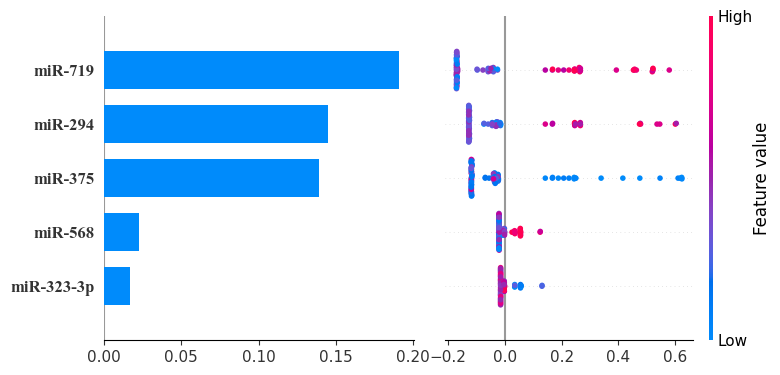

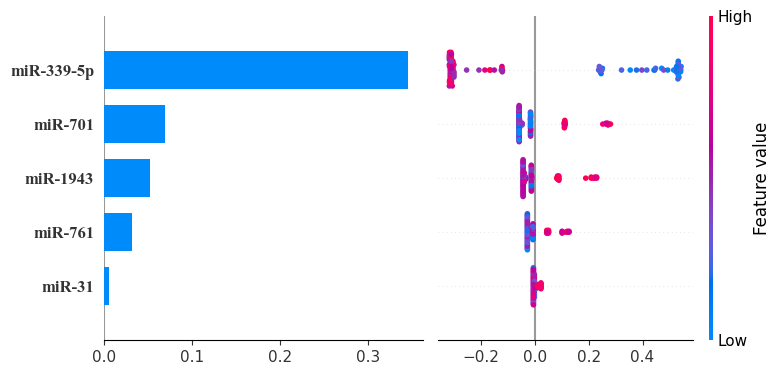

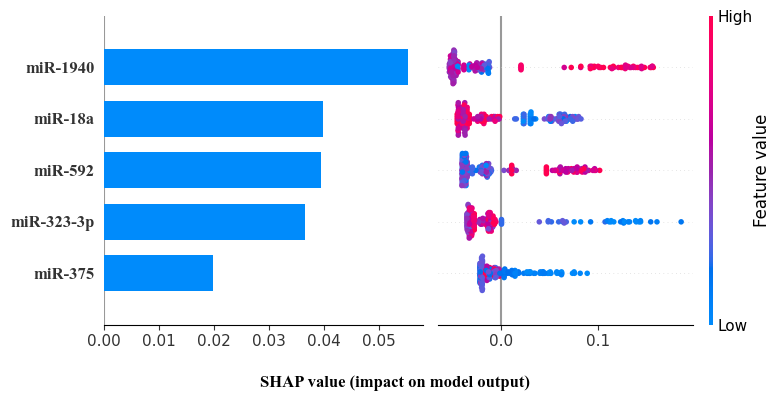

In [20]:
plot_shap_importance_with_summary(
    shap_values_8_weeks[:, :, 1], 
    X_8_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_feature_importance_with_summary_8_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_16_weeks[:, :, 1], 
    X_16_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_feature_importance_with_summary_16_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_all_weeks[:, :, 1], 
    X_all_weeks, 
    title='',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_feature_importance_with_summary_all_weeks.png'
)

## SHAP heatmaps

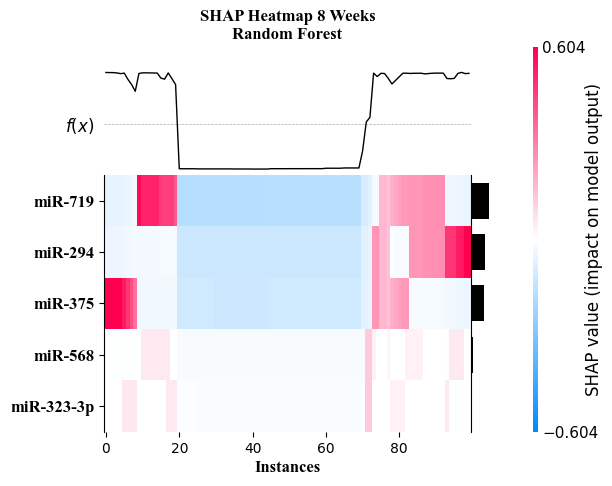

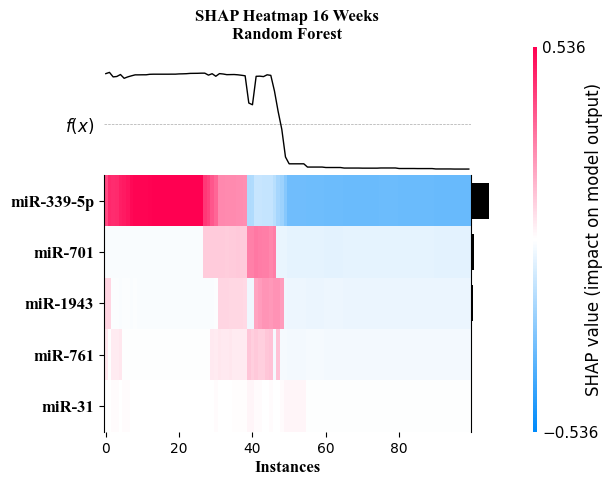

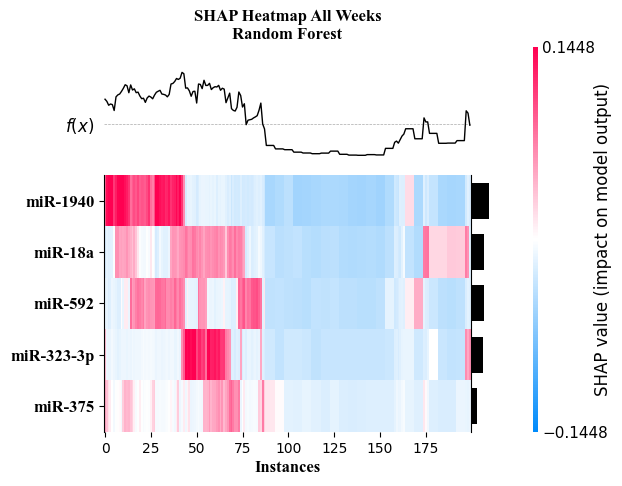

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
plot_shap_heatmap(
    top_shap_values(shap_values_8_weeks[:, :, 1]), 
    "SHAP Heatmap 8 Weeks\nRandom Forest", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Heatmap_8_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_16_weeks[:, :, 1]), 
    "SHAP Heatmap 16 Weeks\nRandom Forest", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Heatmap_16_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_all_weeks[:, :, 1]), 
    "SHAP Heatmap All Weeks\nRandom Forest", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Heatmap_All_Weeks.png'
)

## SHAP dependence plots

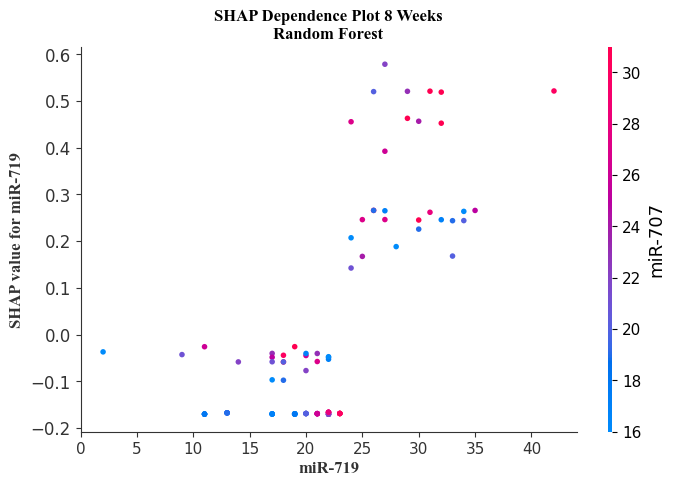

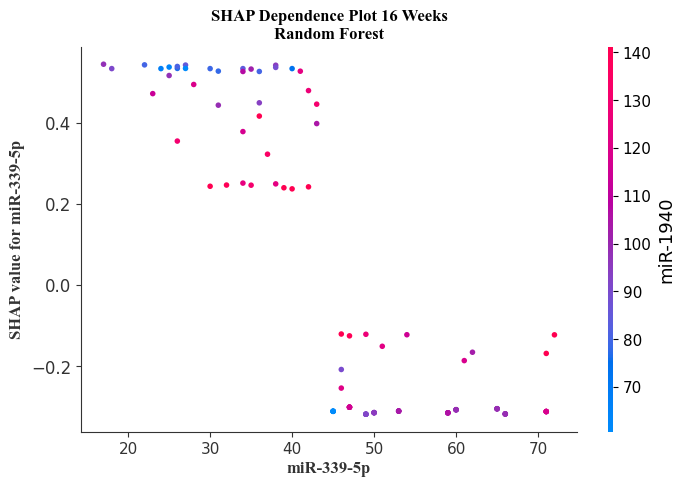

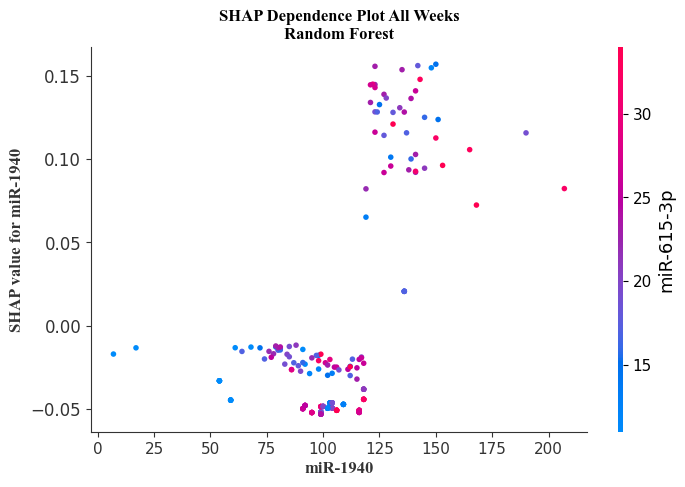

In [22]:
plot_shap_dependence(
    shap_values_8_weeks[:, :, 1], 
    X_8_weeks, 
    "SHAP Dependence Plot 8 Weeks\nRandom Forest", 
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Dependence_Plot_8_Weeks.png'
)

plot_shap_dependence(
    shap_values_16_weeks[:, :, 1], 
    X_16_weeks, 
    "SHAP Dependence Plot 16 Weeks\nRandom Forest", 
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Dependence_Plot_16_Weeks.png'
)

plot_shap_dependence(
    shap_values_all_weeks[:, :, 1], 
    X_all_weeks, 
    "SHAP Dependence Plot All Weeks\nRandom Forest", 
    save_fig=True,
    file_name='all_pathogens_randomforest_SHAP_Dependence_Plot_All_Weeks.png'
)